# Causal Inference Using Pearl's Framework

## Objectives:

- Perform a causal inference task using Pearl’s framework;
- Infer the causal graph from observational data and then validate the graph;
- Merge machine learning with causal inference;


## Load Data and Libraries

In [43]:
# Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import causalnex
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import os
import sys

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load Data

raw_df = pd.read_csv("../data/data.csv")
raw_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
# Check Dataset

raw_df.shape

(569, 33)

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### Observation
- There are 569 rows and 33 columns
- The last column is completely empty
- There is no Null value in any of the other columns.
- All the variables are float type except for the Id column and the diagnosis variable which is string.

## Clean Data

In [7]:
# removing null column
clean_df = raw_df.iloc[:,:-1]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### check for outliers

In [8]:
def check_outlier(df):
    tmp_info = df.describe()

    Q1 = np.array(tmp_info.iloc[4,:].values.flatten().tolist())
    Q3 = np.array(tmp_info.iloc[6,:].values.flatten().tolist())

    # calculate the Inerquartile range.
    IQR = Q3-Q1
    L_factor = IQR*1.5
    H_factor = IQR*3

    # Minor Outliers will lie outside the Inner fence
    Inner_Low = Q1-L_factor
    Inner_High = Q3 + L_factor
    inner_fence = [Inner_Low, Inner_High]

    # Major Outliers will lie outside the Outer fence
    Outer_Low = Q1-H_factor
    Outer_High = Q3+H_factor
    outer_fence = [Outer_Low, Outer_High]
    
    outliers = []
    for col_index in range(df.shape[1]):
        
        inner_count = 0
        outer_count = 0
        tmp_list = df.iloc[:,col_index].tolist()
        for value in tmp_list:
            if((value < inner_fence[0][col_index]) or (value > inner_fence[1][col_index])):
                inner_count = inner_count + 1
            elif((value < outer_fence[0][col_index]) or (value > outer_fence[1][col_index])):
                outer_count = outer_count + 1

        outliers.append({df.columns[col_index]:[inner_count, outer_count]})
        
    return outliers
             


In [9]:
test = check_outlier(clean_df.iloc[:,2:])
test

[{'radius_mean': [14, 0]},
 {'texture_mean': [7, 0]},
 {'perimeter_mean': [13, 0]},
 {'area_mean': [25, 0]},
 {'smoothness_mean': [6, 0]},
 {'compactness_mean': [16, 0]},
 {'concavity_mean': [18, 0]},
 {'concave points_mean': [10, 0]},
 {'symmetry_mean': [15, 0]},
 {'fractal_dimension_mean': [15, 0]},
 {'radius_se': [38, 0]},
 {'texture_se': [20, 0]},
 {'perimeter_se': [38, 0]},
 {'area_se': [65, 0]},
 {'smoothness_se': [30, 0]},
 {'compactness_se': [28, 0]},
 {'concavity_se': [22, 0]},
 {'concave points_se': [19, 0]},
 {'symmetry_se': [27, 0]},
 {'fractal_dimension_se': [28, 0]},
 {'radius_worst': [17, 0]},
 {'texture_worst': [5, 0]},
 {'perimeter_worst': [15, 0]},
 {'area_worst': [35, 0]},
 {'smoothness_worst': [7, 0]},
 {'compactness_worst': [16, 0]},
 {'concavity_worst': [12, 0]},
 {'concave points_worst': [0, 0]},
 {'symmetry_worst': [23, 0]},
 {'fractal_dimension_worst': [24, 0]}]

### Observation
- There are no major outliers
- There are some minor outliers in each row
- There are no Null values

## Extract Features

In [10]:
# select only variables with mean values

features_df = clean_df.iloc[:,2:12]
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   radius_mean             569 non-null    float64
 1   texture_mean            569 non-null    float64
 2   perimeter_mean          569 non-null    float64
 3   area_mean               569 non-null    float64
 4   smoothness_mean         569 non-null    float64
 5   compactness_mean        569 non-null    float64
 6   concavity_mean          569 non-null    float64
 7   concave points_mean     569 non-null    float64
 8   symmetry_mean           569 non-null    float64
 9   fractal_dimension_mean  569 non-null    float64
dtypes: float64(10)
memory usage: 44.6 KB


In [11]:
# Convert target variable from String column to int
def convert(x):
    if(x=="M"):
        return 0
    else:
        return 1
    
target = clean_df["diagnosis"]
target = target.apply(lambda x: convert(x))
print(target.value_counts())


1    357
0    212
Name: diagnosis, dtype: int64


In [12]:
# scaling variables

scaler = MinMaxScaler()
scaled_df = features_df.copy() 
scaled_df.iloc[:,2:] = scaler.fit_transform(scaled_df.iloc[:,2:])
scaled_df


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,17.99,10.38,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518
1,20.57,17.77,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323
2,19.69,21.25,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247
3,11.42,20.38,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000
4,20.29,14.34,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816
...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,0.678668,0.566490,0.526948,0.296055,0.571462,0.690358,0.336364,0.132056
565,20.13,28.25,0.604036,0.474019,0.407782,0.257714,0.337395,0.486630,0.349495,0.113100
566,16.60,28.08,0.445788,0.303118,0.288165,0.254340,0.216753,0.263519,0.267677,0.137321
567,20.60,29.33,0.665538,0.475716,0.588336,0.790197,0.823336,0.755467,0.675253,0.425442


### Observation

- Only variables with mean values were selected
- using minMax scaler each of the float values were scaled

## Perform Exploratory Analysis

### Univariate Analysis

In [13]:
# Univariate Analysis
scaled_df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,0.332935,0.216920,0.394785,0.260601,0.208058,0.243137,0.379605,0.270379
std,3.524049,4.301036,0.167915,0.149274,0.126967,0.161992,0.186785,0.192857,0.138456,0.148702
min,6.981000,9.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.700000,16.170000,0.216847,0.117413,0.304595,0.139685,0.069260,0.100944,0.282323,0.163016
50%,13.370000,18.840000,0.293345,0.172895,0.390358,0.224679,0.144189,0.166501,0.369697,0.243892
75%,15.780000,21.800000,0.416765,0.271135,0.475490,0.340531,0.306232,0.367793,0.453030,0.340354
max,28.110000,39.280000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:title={'center':'concavity_mean'}, ylabel='Frequency'>

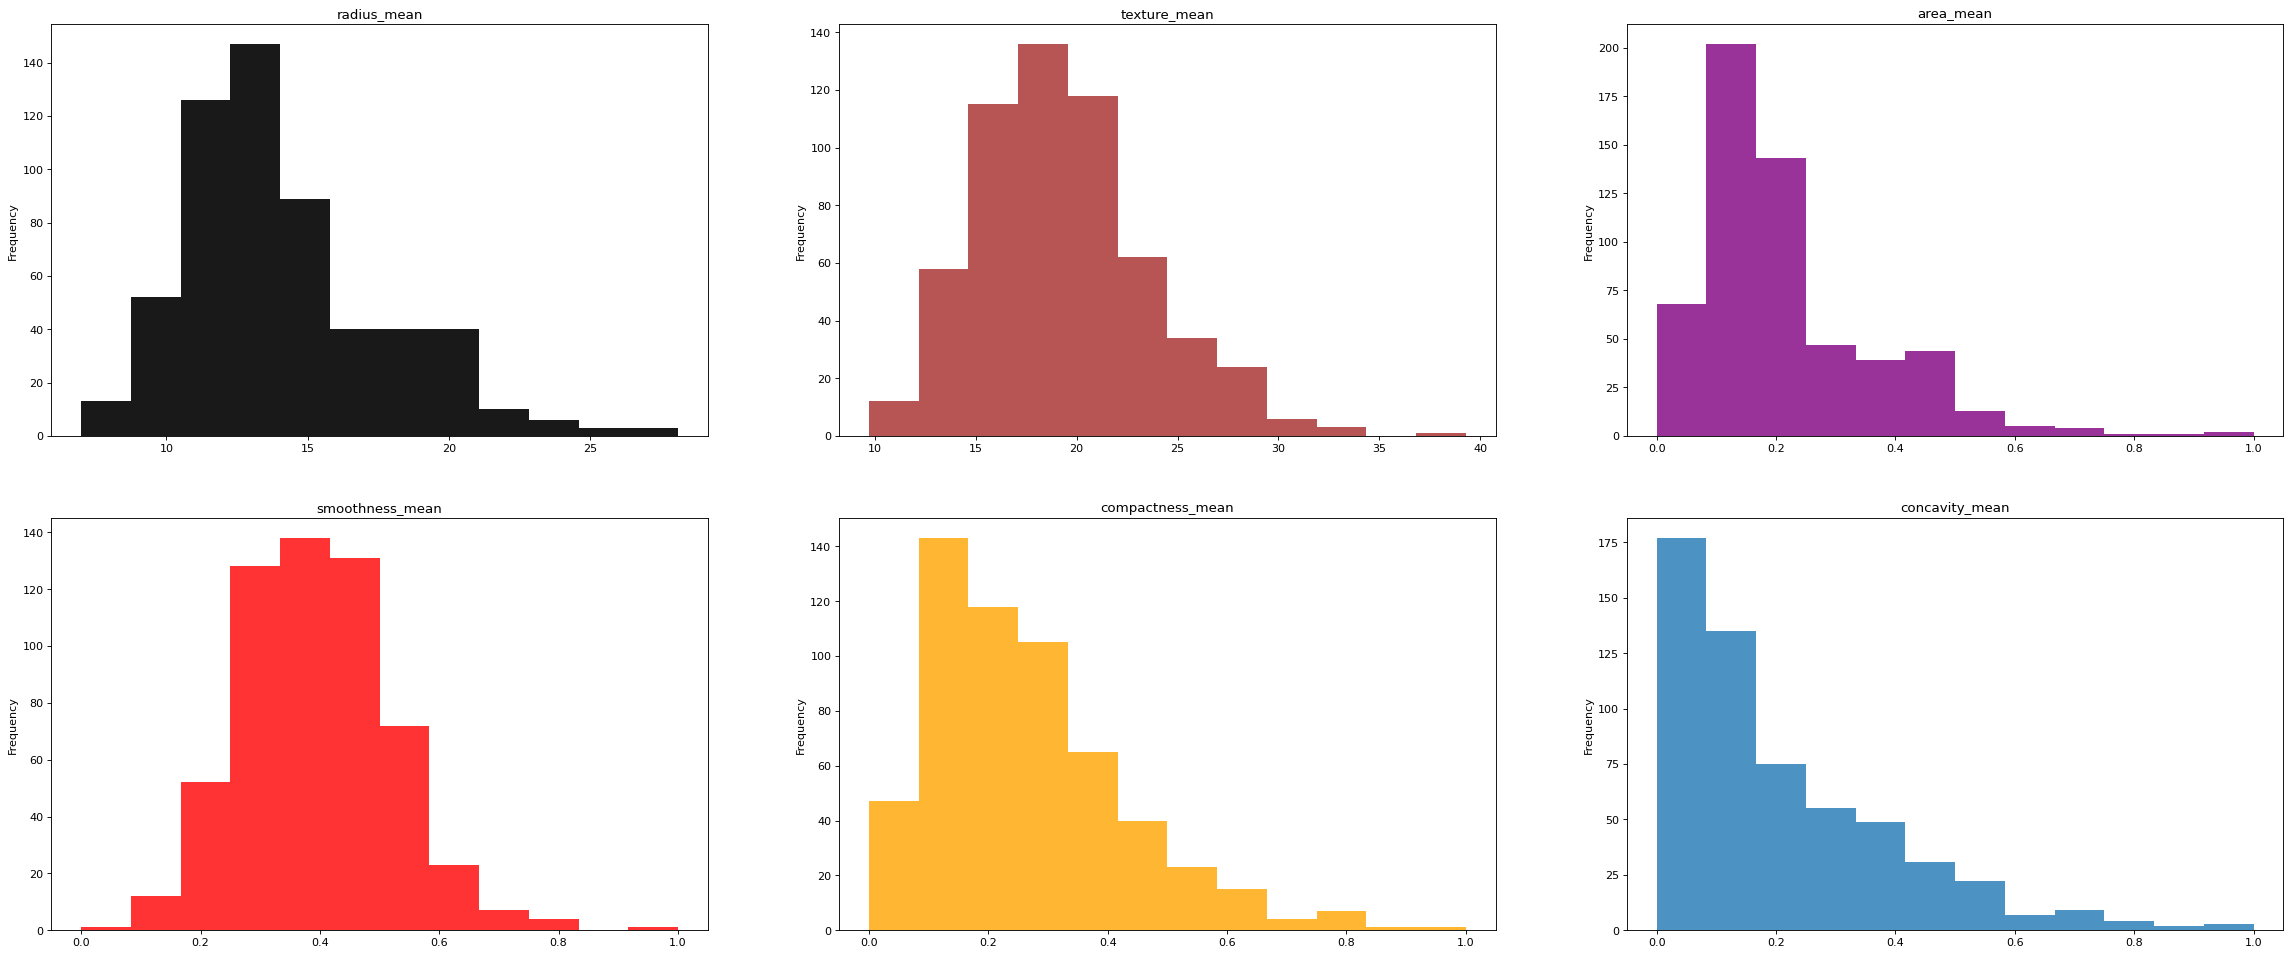

In [14]:
plt.figure(figsize=(36, 15), dpi=80)
plt.subplot(2, 3, 1)
plt.title("radius_mean")
scaled_df["radius_mean"].plot.hist(bins=12, color="black", alpha=0.9)

#plot 2
plt.subplot(2, 3, 2)
plt.title("texture_mean")
scaled_df["texture_mean"].plot.hist(bins=12, color="brown", alpha=0.8)

#plot 3
plt.subplot(2, 3, 3)
plt.title("area_mean")
scaled_df["area_mean"].plot.hist(bins=12, color="purple", alpha=0.8)

#plot 4
plt.subplot(2, 3, 4)
plt.title("smoothness_mean")
scaled_df["smoothness_mean"].plot.hist(bins=12, color="red", alpha=0.8)

#plot 5
plt.subplot(2, 3, 5)
plt.title("compactness_mean")
scaled_df["compactness_mean"].plot.hist(bins=12, color="orange", alpha=0.8)

#plot 6
plt.subplot(2, 3, 6)
plt.title("concavity_mean")
scaled_df["concavity_mean"].plot.hist(bins=12, alpha=0.8)

### Bivariate Analysis

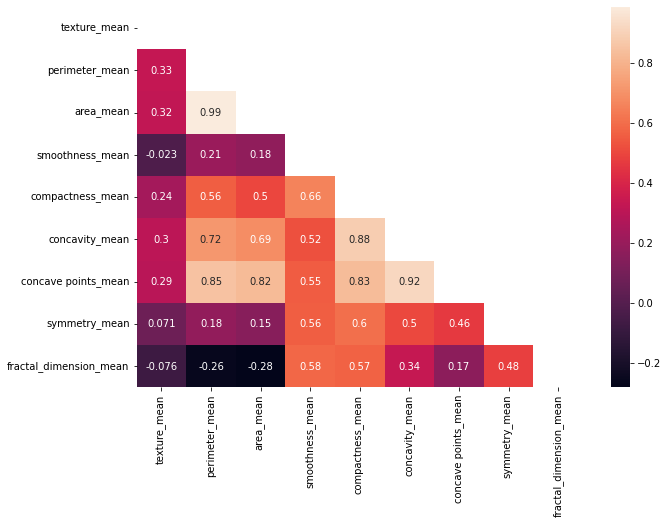

In [15]:
# bivariate Analysis
# correlation matrix
corr_matrix = scaled_df.iloc[:,1:].corr()
matrix = np.triu(corr_matrix)
fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(corr_matrix, annot=True, mask=matrix)

### Observation
- The Distribution of the variables is right skewed
- There is a large correlation between radius and concave points, concavity and conpactness
- there is a large positive correlation between smoothness and compactness, fractal dimension.

## Discover Causal Graphs

In [17]:
# split the data 
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)
train_df = X_train.copy()
train_df["target"] = y_train

In [29]:
int(len(train_df)*0.2)

79

In [46]:
factor = len(train_df)/100
train_20 = train_df.sample(int(20*factor), random_state=11)
train_40 = train_df.sample(int(40*factor), random_state=11)
train_60 = train_df.sample(int(60*factor), random_state=11)
train_80 = train_df.sample(int(80*factor), random_state=11)
train_100 = train_df.copy()

In [41]:
def plot_graph(sm):
  viz = plot_structure(
      sm,
      graph_attributes={"scale": "2.0", 'size': 2.5},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
  return Image(viz.draw(format='png'))

In [48]:
sm20 = from_pandas(train_20, tabu_parent_nodes=["target"])

In [49]:
sm40 = from_pandas(train_40, tabu_parent_nodes=["target"])

In [50]:
sm60 = from_pandas(train_60, tabu_parent_nodes=["target"])

In [51]:
sm80 = from_pandas(train_80, tabu_parent_nodes=["target"])

In [ ]:
sm100 = from_pandas(train_100, tabu_parent_nodes=["target"])

### Check Stability

In [ ]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)), 3)

## Evaluate Causal Graphs and Optimize

## Model

## Compare Models